# Thermal Blooming Demo

This notebook demonstrates the functionality of the thermal blooming wavefront error included in the thermal_blooming branch of `poppy`.

## Basics

Thermal blooming is a self-induced distortion of a high power laser beam whose origin is the heating of the medium through which the beam propagates due to absorption. As a result of the heating, the medium expands which effects its refractive index. Effectively, a thermal lens is formed which spreads, bends and distorts the wavefront. A short (and incomplete) overview of the theory is given in

F. G. Gebhardt, “Twenty-five years of thermal blooming: an overview”, in Propagation of High-Energy Laser Beams Through the Earth's Atmosphere, vol. 1221, International Society for Optics and Photonics, 1990, pp. 2–26.

The relevant transport mechanism for the generated heat are heat transfer, forced (external wind), and natural convection. They determine the density of the medium and thus, its refractive index. The theory to describe these changes are based on the thermodynamic equations, i.e. the continuity, Navier-Stokes, and heat transfer equations. An elaborate study of the theory and base for the implementation used in `poppy` are these two papers (but beware, a plethora of typos in them):

[1] J. A. Fleck Jr, J. R. Morris, and M. D. Feit, “Time-dependent propagation of high energy laser beams through the atmosphere,” Appl. Phys., vol. 10, no. 2, pp. 129–160, 1976.

[2] J. A. Fleck Jr, J. R. Morris, and M. D. Feit, “Time-dependent propagation of high-energy laser beams through the atmosphere: II,” Appl. Phys., vol. 14, no. 1, pp. 99–115, 1977.

Two approximations for cw beams (the theory about multi-pulse heating is also contained in these papers) have been implemented:
1. isobaric
2. non-isobaric

Both neglect heat transfer and natural convection which restricts the applicability to situations where the external wind is sufficiently large so that forced convection dominates the heat transfer. However, in this publication

D. C. Smith, “High-power laser propagation: Thermal blooming,” Proc. IEEE, vol. 65, no. 12, pp. 1679–1714, 1977.

the author gives an approximation of the natural convection fluid velocity which can be used to still use the forced convection dominated approximation. The main difference between the isobaric and non-isobaric approximation is that in the first one, the external wind velocity can be applied to only one direction (either x or y) and viscosity of the propagation medium is neglected. The non-isobaric approximation allows an arbitrary in-plane external wind direction and considers viscosity. However, this will be reflected in the compuation time. In both cases, when a vanishing externel wind velocity is given, the natural convection velocity will be approximated (which will point in the negative y-direction) and used instead.

**Crucial note:** It is important to use `poppy`s PhysicalFresnelWavefront class and **not** FresnelWavefront or Wavefront. This is because thermal blooming is non-linear effect that depends on the intensity which will need to have physical units (W/m$^2$). The other two classes use different unit conventions which will lead to incorrect results.

## Example 1: Test against literature

Let us first test how accurate the results from `poppy`s thermal blooming implementation resemble those from the literature. For this purpose, let us recalculate Fig. 6 from this publication:

F. G. Gebhardt, “High power laser propagation,” Appl. Opt., vol. 15, no. 6, pp. 1479–1493, Jun. 1976.

The values we use can be found in Tab. 1. Lets start by defining the variables:

In [6]:
import numpy as np
import poppy
import astropy.units as u
import matplotlib.pyplot as plt
from copy import deepcopy


w0 = 14.15*u.cm            # beam radius
P0 = 100e3                 # beam power (W)
L = 2.0*u.km               # propagation distance
w_extend = 5               # weight of the spatial extend
wavelength = 10.6*u.um     # wavelength in vacuum
M2 = 1.0                   # beam quality factor
n0 = 1.00027398            # ambient refractive index of air @ 15 deg C
R0 = L                     # initial radius of curvature
npix = 512                 # number of pixels
oversample = 2             # oversampling factor
aero_abs_coeff = 7e-7/u.cm # absorption coefficient due to aerosols
nz = 20                    # number of phase screens
dz = L/nz                  # propagation step
v0x = 200.0*u.cm/u.s       # ambient wind velocity in x-direction
v0y = 0.0*u.m/u.s          # ambient wind velocity in y-direction

Next, let us make wavefront (and remember, it is crucial to use the PhysicalFresnelWavefront here):

In [7]:
wf = poppy.PhysicalFresnelWavefront(beam_radius=w_extend*w0,
                                    wavelength=wavelength,
                                    units=u.m,
                                    npix=npix,
                                    oversample=oversample,
                                    M2=M2, n0=n0)
wf *= poppy.GaussianAperture(w=w0)
wf *= poppy.QuadPhase(-R0)
wf.scale_power(P0)

Next, we propagate the wavefront to $L$ in $n_z$ steps where we apply the split-step propagation method. That means that we have to make an initial half step propagation after which full steps follow. In the end, there is another half step to propagate. For more information, see

J. A. Fleck Jr, J. R. Morris, and M. D. Feit, “Time-dependent propagation of high energy laser beams through the atmosphere,” Appl. Phys., vol. 10, no. 2, pp. 129–160, 1976.

In [8]:
for l in range(nz+1):
    if l==0 or l==nz:
        delta = dz/2
    else:
        delta = dz
    wf.propagate_fresnel(delta)
    if l != nz:
        phase_screen = poppy.ThermalBloomingWFE(aero_abs_coeff, delta, v0x=v0x, direction='x', isobaric=True)    
        wf *= phase_screen

Thermal blooming relies on a multitude of variables such as external wind direction and speed, absorption coefficient, temperature, and a pile of material parameters like specific heat capacities, mass density, refractive index, and dynamic viscosity. By default, `poppy` assumes values for dry air at room temperature.

Now, lets plot the result as done in the reference publication:

(-0.4, 0.4)

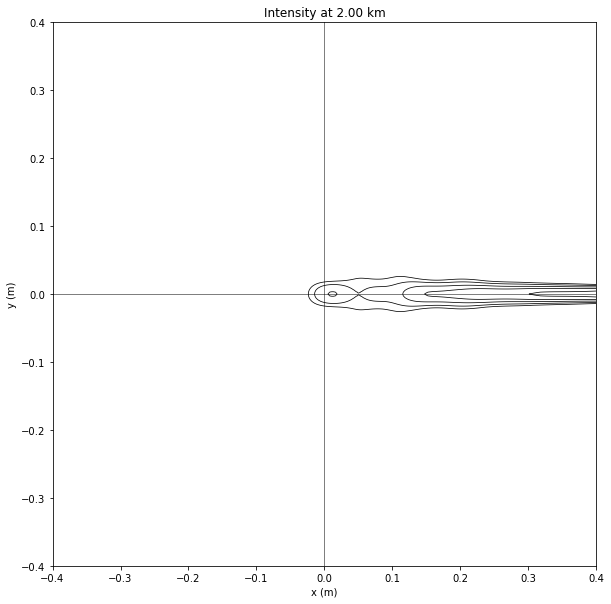

In [9]:
y, x = wf.coordinates()
z = wf.intensity.T
idx = np.unravel_index(np.argmax(z, axis=None), z.shape)

fig = plt.figure(figsize=(20,10))
fig.clf()

levels = np.array([0.09, 0.14, 0.23, 0.36, 0.57, 0.9])*z.max()
ax = fig.add_subplot(111)
cf = ax.contour(x, y, z, levels=levels, colors='k', linewidths=0.75)
plt.plot([0.0, 0.0], [x.min(), x.max()], '-k', lw=0.5)
plt.plot([x.min(), x.max()], [0.0, 0.0], '-k', lw=0.5)
plt.plot([x[0,:][idx[1]]], [x[0,:][idx[0]]], 'xr')
ax.set_title('Intensity at {0:0.2f}'.format(wf.z.to(u.km)))
ax.set_aspect('equal')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim([-0.4, 0.4])
ax.set_ylim([-0.4, 0.4])

Finally, lets have a look at the Figure from the reference, which looks pretty similar:

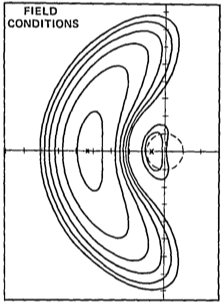

In [5]:
from IPython.display import Image 
pil_img = Image(filename='Figure6.png')
display(pil_img)

The main effects of thermal blooming are visible: formation of intensity isles, shifting of the beam center, and a typical half-moon shaped intensity profile. This emphasizes how critical this effect can be since it can serioulsy limit the power that can be applied at the beams destination.